# Calibración de modelos
**Aprendizaje de Máquina - CEIA - FIUBA**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.calibration import CalibrationDisplay, calibration_curve, CalibratedClassifierCV
from sklearn.metrics import brier_score_loss, log_loss, accuracy_score

from sklearn.pipeline import make_pipeline


## ¿Por qué es importante calibrar modelos?

A continuación vamos a entrenar un modelo **GaussianNB** con un dataset real: [**Breast Cancer Wisconsin**](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic) y vamos a analizar sus probabilidades.

Para eso vamos a usar el [módulo de calibración de ScikitLearn](https://scikit-learn.org/stable/modules/calibration.html).

In [2]:
# Cargamos los datos
data = load_breast_cancer()
X = data.data
y = data.target

print(f"Dataset: {X.shape[0]} muestras, {X.shape[1]} features")
print(f"Clase positiva (benigno): {y.mean():.2%}\n")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)


Dataset: 569 muestras, 30 features
Clase positiva (benigno): 62.74%



Armemos el modelo...

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)

pred_gnb = gnb.predict(X_test)
probs_gnb = gnb.predict_proba(X_test)[:,1]

# Métricas
acc_gnb = accuracy_score(y_test, pred_gnb)

print(f"Accuracy: {acc_gnb:.3f}")

Accuracy:     0.947


Calculemos métricas de calibración para el modelo de Naive Bayes.

Brier Score:  0.049


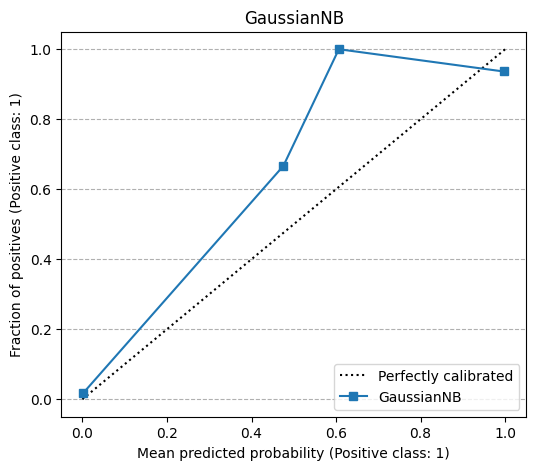

In [4]:
brier_gnb = brier_score_loss(y_test, probs_gnb)

print(f"Brier Score:  {brier_gnb:.3f}")

fig, ax = plt.subplots(figsize=(6, 5))
CalibrationDisplay.from_estimator(gnb, X_test, y_test, ax=ax)
ax.grid(axis='y', ls='--')
plt.title("GaussianNB")
plt.show()


GaussianNB muestra un comportamiento típico de modelos mal calibrados:

- Predice probabilidades muy extremas (cercanas a 0 o 1)
- Su curva sin calibrar queda lejos de la diagonal ideal.


## 1. Datos sintéticos

Vamos a comparar los resultados de modelos sin calibrar vs modelos calibrados, usando datos sintéticos.

In [5]:
X_s, y_s = make_classification(n_samples=10000, n_features=20, n_informative=15,
                                   n_redundant=5, random_state=42, flip_y=0.02)

print(f"Dataset: {X_s.shape[0]} muestras, {X_s.shape[1]} features")
print(f"Clase positiva: {y_s.mean():.2%}\n")

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_s, y_s, test_size=0.3, random_state=42, stratify=y_s)


Dataset: 10000 muestras, 20 features
Clase positiva: 49.97%



Empezamos entrenando con logistic regression.

In [6]:
# 1. Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_s, y_train_s)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


Ahora entrenamos un random forest.

In [7]:
# 2. Random Forest
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train_s, y_train_s)

,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Ahora entrenamos un random forest con calibración Platt scaling (sigmoid).

In [8]:
# 3. Random Forest + calibración Platt Scaling (sigmoid)
rf_platt = CalibratedClassifierCV(rf, method='sigmoid', cv=5)
rf_platt.fit(X_train_s, y_train_s)

,estimator,RandomForestC...ndom_state=42)
,method,'sigmoid'
,cv,5
,n_jobs,None
,ensemble,'auto'
,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


Repetimos, ahora con calibración Isotonic.

In [9]:
# 4. Random Forest + calibración Isotonic
rf_iso = CalibratedClassifierCV(rf, method='isotonic', cv=5)
rf_iso.fit(X_train_s, y_train_s)

,estimator,RandomForestC...ndom_state=42)
,method,'isotonic'
,cv,5
,n_jobs,None
,ensemble,'auto'
,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


Obtengamos ahora las métricas de calibración para los modelos, obteniendo primero las predicciones de probabilidad.

In [10]:
probs_rf = rf.predict_proba(X_test_s)[:, 1]
probs_platt = rf_platt.predict_proba(X_test_s)[:, 1]
probs_iso = rf_iso.predict_proba(X_test_s)[:, 1]

#### Probabilidad original vs calibrada

Grafiquemos las predicciones originales vs las calibradas:

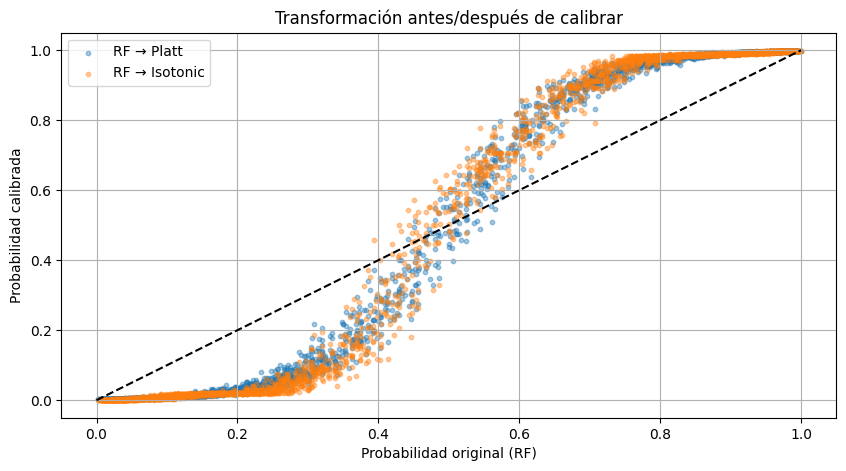

In [11]:
plt.figure(figsize=(10, 5))

plt.scatter(probs_rf, probs_platt, s=10, alpha=0.4, label="RF → Platt")
plt.scatter(probs_rf, probs_iso, s=10, alpha=0.4, label="RF → Isotonic")

plt.plot([0,1],[0,1],'k--') 
plt.xlabel("Probabilidad original (RF)")
plt.ylabel("Probabilidad calibrada")
plt.title("Transformación antes/después de calibrar")
plt.legend()
plt.grid(True)
plt.show()


Este gráfico nos muestra exactamente cómo la calibración transforma las probabilidades. Cada punto es una predicción. En el eje X tenemos la probabilidad original y en el eje Y la probabilidad calibrada.

#### Curvas de calibración (o Reliability Diagrams)

Las curvas de calibración comparan la confianza predicha vs la frecuencia real.
Si la línea está cerca o sobre la diagonal, las probabilidades son buenas, la calibración es perfecta.

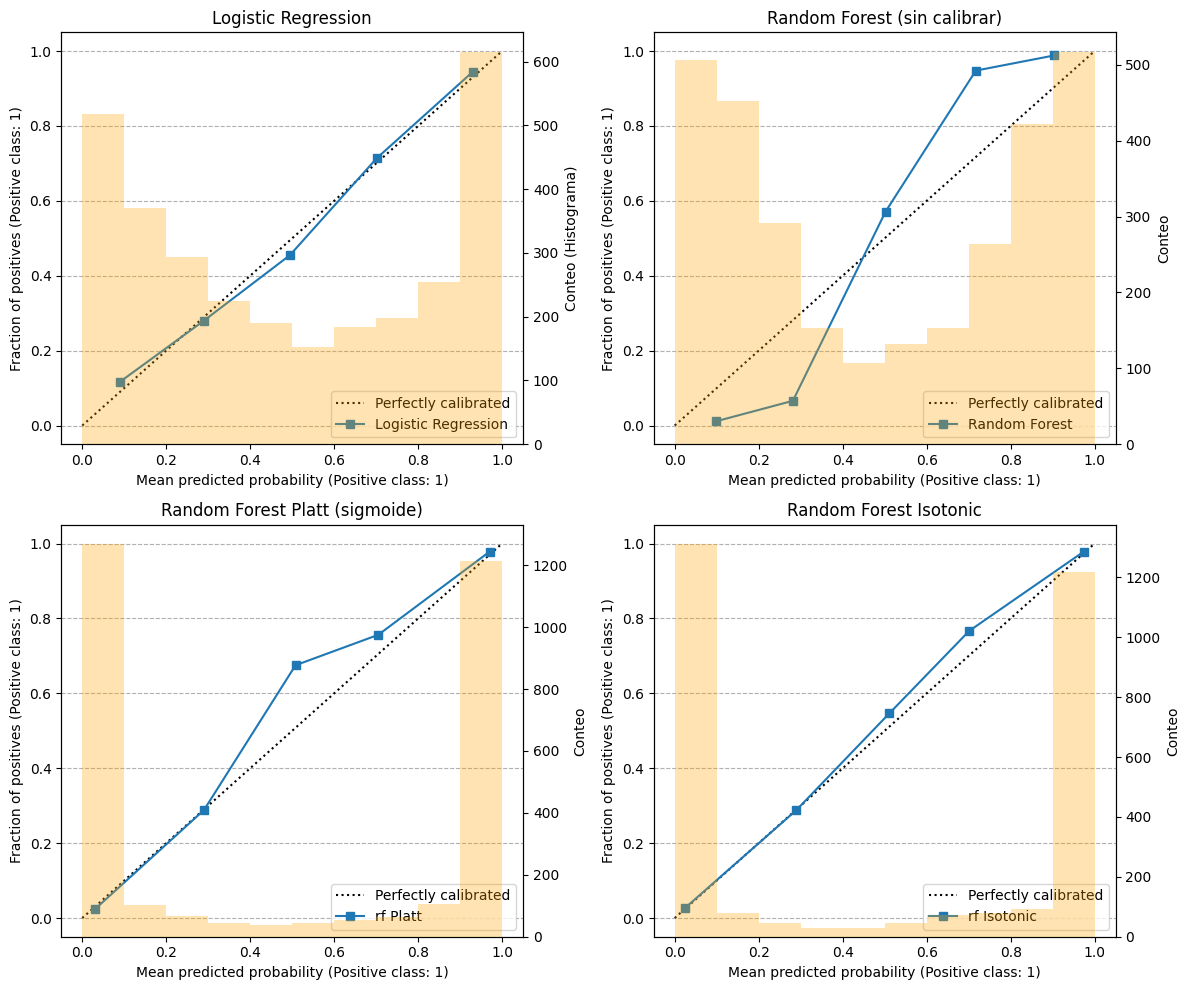

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# --- Configuración común del histograma ---
hist_params = {'bins': 10, 'range': (0, 1), 'alpha': 0.3, 'color': 'orange', 'edgecolor': 'none'}

# 1. Logistic Regression
ax1 = axes[0, 0]
CalibrationDisplay.from_estimator(lr, X_test_s, y_test_s, name='Logistic Regression', ax=ax1)
# Calculamos probabilidades para el histograma
prob_lr = lr.predict_proba(X_test_s)[:, 1]
# Creamos eje gemelo
ax1_hist = ax1.twinx()
ax1_hist.hist(prob_lr, **hist_params)
ax1_hist.set_ylabel("Conteo (Histograma)") # Opcional
ax1.set_title("Logistic Regression")
ax1.grid(axis="y", ls='--')


# 2. Random Forest (Sin calibrar)
ax2 = axes[0, 1]
CalibrationDisplay.from_estimator(rf, X_test_s, y_test_s, name='Random Forest', ax=ax2)
prob_rf = rf.predict_proba(X_test_s)[:, 1]
ax2_hist = ax2.twinx()
ax2_hist.hist(prob_rf, **hist_params)
ax2_hist.set_ylabel("Conteo")
ax2.set_title("Random Forest (sin calibrar)")
ax2.grid(axis="y", ls='--')


# 3. Random Forest Platt
ax3 = axes[1, 0]
CalibrationDisplay.from_estimator(rf_platt, X_test_s, y_test_s, name='rf Platt', ax=ax3)
prob_platt = rf_platt.predict_proba(X_test_s)[:, 1]
ax3_hist = ax3.twinx()
ax3_hist.hist(prob_platt, **hist_params)
ax3_hist.set_ylabel("Conteo")
ax3.set_title("Random Forest Platt (sigmoide)")
ax3.grid(axis="y", ls='--')


# 4. Random Forest Isotonic
ax4 = axes[1, 1]
CalibrationDisplay.from_estimator(rf_iso, X_test_s, y_test_s, name='rf Isotonic', ax=ax4)
prob_iso = rf_iso.predict_proba(X_test_s)[:, 1]
ax4_hist = ax4.twinx()
ax4_hist.hist(prob_iso, **hist_params)
ax4_hist.set_ylabel("Conteo")
ax4.set_title("Random Forest Isotonic")
ax4.grid(axis="y", ls='--')

plt.tight_layout()
plt.show()

#### ¿Qué revelan estas curvas?

- Logistic regression suele estar bien calibrada (queda casi pegada a la diagonal).
- Random Forest (sin calibrar) es muy confiado (la curva está aplastada en 0 y 1).
- Random Forest + Platt mejora mucho (queda cerca de la línea perfecta).
- Random Forest + Isotonic mejora muchísimo (queda muy cerca de la línea perfecta).

#### Métricas

El `Brier Score` mide qué tan lejos están las probabilidades de la realidad. Mientras más bajo, mejor.

In [20]:
def resumen_calibracion(y, probs):
    return {
        "Brier": brier_score_loss(y, probs),
        "LogLoss": log_loss(y, probs),
        "Accuracy": accuracy_score(y, (probs >= 0.5))
    }

modelos = {
    "Logistic Regression": lr.predict_proba(X_test_s)[:,1],
    "RF (sin calibrar)": rf.predict_proba(X_test_s)[:,1],
    "Platt": rf_platt.predict_proba(X_test_s)[:,1],
    "Isotonic": rf_iso.predict_proba(X_test_s)[:,1],
}

print(pd.DataFrame({k: resumen_calibracion(y_test_s, v) for k,v in modelos.items()}).T)


                        Brier   LogLoss  Accuracy
Logistic Regression  0.132040  0.414975  0.818333
RF (sin calibrar)    0.061483  0.243888  0.952333
Platt                0.040546  0.153393  0.948000
Isotonic             0.040537  0.183336  0.950667


**Pero por qué la regresión logística tiene peor Brier Score que el Random Forest?**

La regresión logística presentó en la curva de calibración que se ajusta casi perfectamente a la curva ideal, lo que indica que el modelo está calibrado correctamente. Pero el Brier Score, tal como lo calculamos no solo mide la calibración, sino la discriminación. Por ejemplo, si tenemos un caso Positivo (1):

- La regresión logística predice una probabilidad de 0.55, el error es de $(1 - 0.55)^2 \approx 0.2$
- El Random Forest predice una probabilidad de 0.9, el error es de $(1 - 0.9)^2 \approx 0.01$

Dada la descomposición del Brier Score, el Random Forest tiene un error menor que la regresión logística, lo que indica que el Random Forest tiene mejor discriminación que la regresión logística, haciendo que esta métrica sea más baja. Por lo que cuando usamos el Brier Score, no solo evaluamos calibración, sino también discriminación. 

---
## 2. Dataset real: Breast Cancer Wisconsin

Repetimos el experimento de calibración con el modelo Naive-Bayes y el dataset Breast Cancer Wisconsin.

In [57]:
data = load_breast_cancer()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Entrenamos un Bayesiano
gnb = make_pipeline(
    StandardScaler(),
    GaussianNB() 
)

gnb.fit(X_train, y_train)

,steps,"[('standardscaler', ...), ('gaussiannb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,priors,None
,var_smoothing,1e-09


Ahora armamos la versión calibrada:

In [58]:
gnb_iso = make_pipeline(
    StandardScaler(),
    CalibratedClassifierCV(
        estimator=GaussianNB(),
        method='isotonic', cv=5
    )
)
gnb_iso.fit(X_train, y_train)

,steps,"[('standardscaler', ...), ('calibratedclassifiercv', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,estimator,GaussianNB()
,method,'isotonic'
,cv,5
,n_jobs,None


Veamos los resultados:

In [61]:
probs_gnb = gnb.predict_proba(X_test)[:, 1]
probs_iso = gnb_iso.predict_proba(X_test)[:, 1]

#### Histogramas

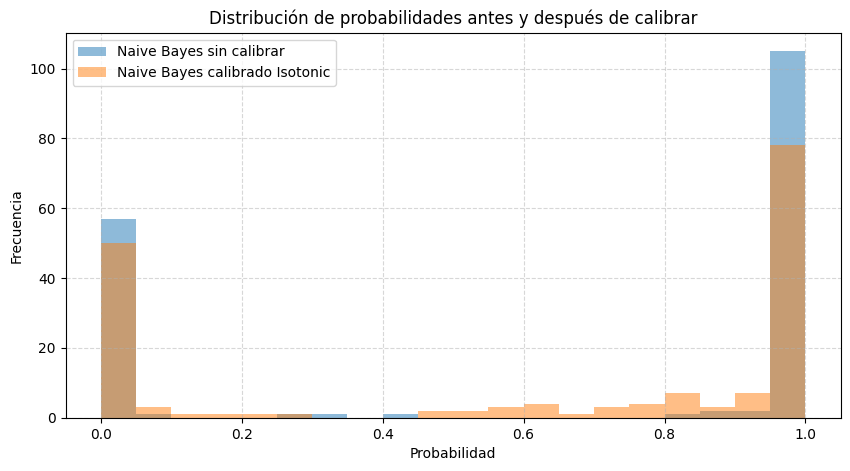

In [62]:
plt.figure(figsize=(10, 5))

# modelo sin calibrar
plt.hist(probs_gnb, bins=20, alpha=0.5, label="Naive Bayes sin calibrar")

# modelo calibrado con Isotonic
plt.hist(probs_iso, bins=20, alpha=0.5, label="Naive Bayes calibrado Isotonic")

plt.xlabel("Probabilidad")
plt.ylabel("Frecuencia")
plt.title("Distribución de probabilidades antes y después de calibrar")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()


### Función para graficar la curva de calibración

Armemos una función para graficar la curva de calibración.

In [68]:
def plot_calibration(y_true, probs_dict, title="Curva de calibración", size=(9,6)):
    plt.figure(figsize=size)
    plt.plot([0, 1], [0, 1], "k--", label="Perfectamente calibrado")

    colors = plt.cm.Dark2.colors 
    
    for i, (name, prob) in enumerate(probs_dict.items()):
        color = colors[i % len(colors)]
        
        frac_pos, mean_pred = calibration_curve(
            y_true, prob, n_bins=5
        )
        brier = brier_score_loss(y_true, prob)
        acc = accuracy_score(y_true, (prob >= 0.5).astype(int))

        plt.plot(mean_pred, frac_pos, marker="o", color=color, linewidth=2,
                 label=f"{name}\nBrier={brier:.3f} | Acc={acc:.3f}")

    plt.xlabel("Probabilidad predicha media")
    plt.ylabel("Fracción de positivos reales")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


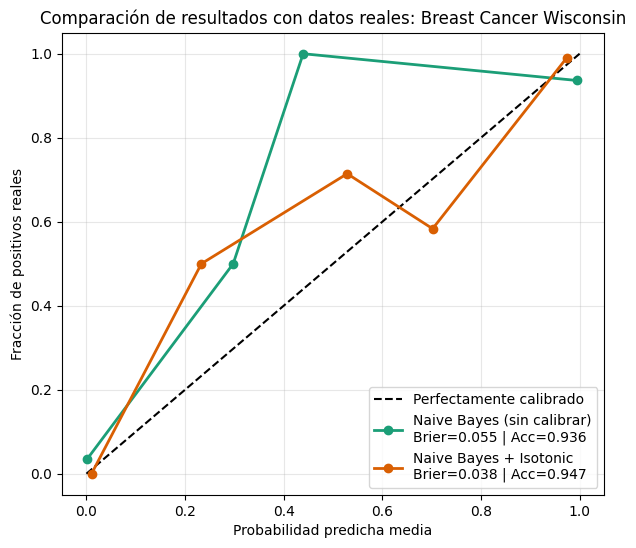

In [70]:
probs = {
    "Naive Bayes (sin calibrar)": gnb.predict_proba(X_test)[:, 1],
    "Naive Bayes + Isotonic": gnb_iso.predict_proba(X_test)[:, 1]
}

plot_calibration(y_test, probs, "Comparación de resultados con datos reales: Breast Cancer Wisconsin", size=(7,6))

#### Métricas

In [71]:
def resumen_calibracion(y, probs):
    return {
        "Brier": brier_score_loss(y, probs),
        "LogLoss": log_loss(y, probs),
        "Accuracy": (probs >= 0.5).mean()
    }

modelos = {
    "NB (sin calibrar)": gnb.predict_proba(X_test)[:,1],
    "Isotonic": gnb_iso.predict_proba(X_test)[:,1],
}

print(pd.DataFrame({k: resumen_calibracion(y_test, v) for k,v in modelos.items()}).T)


                      Brier   LogLoss  Accuracy
NB (sin calibrar)  0.055406  0.363561  0.643275
Isotonic           0.038081  0.117748  0.654971
